In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from hsbmpy import get_max_available_L
from hsbmpy import get_file
import tensorflow as tf

In [ ]:
import importlib, geneontology
from geneontology import *
importlib.reload(geneontology)
from geneontology import *

In [116]:
algorithm = 'lda'
directory = "/home/jovyan/work/phd/datasets/paper/gtexall"
L=get_max_available_L(directory, algorithm)-1
os.chdir(directory)

In [117]:
df_Pwt = pd.read_csv("%s/%s_level_%d_word-dist.csv"%(algorithm,algorithm,L), index_col=0)

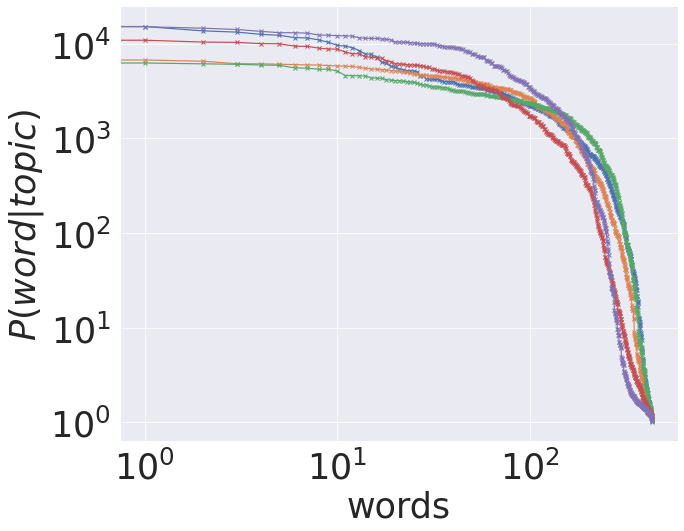

In [118]:
fig=plt.figure(figsize=(10,8))
plt.title("")
for topic in df_Pwt.columns[:5]:
    dist = df_Pwt.sort_values(by=[topic], ascending=False)[topic].astype(float)
    dist = dist[dist>1e-50].values
    if len(dist)<2:
        pass
    plt.plot(np.sort(dist[dist>0].T)[::-1], marker='x', label=topic)
plt.ylabel("$P(word | topic)$", fontsize=35)
plt.xlabel("words", fontsize=35)
plt.xscale('log')
plt.yscale('log')
plt.tick_params(which="both",labelsize=35)
#plt.legend()
plt.show()
fig.savefig("p_w_tw_%s.pdf"%algorithm)

In [119]:
df_Ptd = pd.read_csv("%s/%s_level_%d_topic-dist.csv"%(algorithm,algorithm,L), index_col=1).drop('i_doc',1)

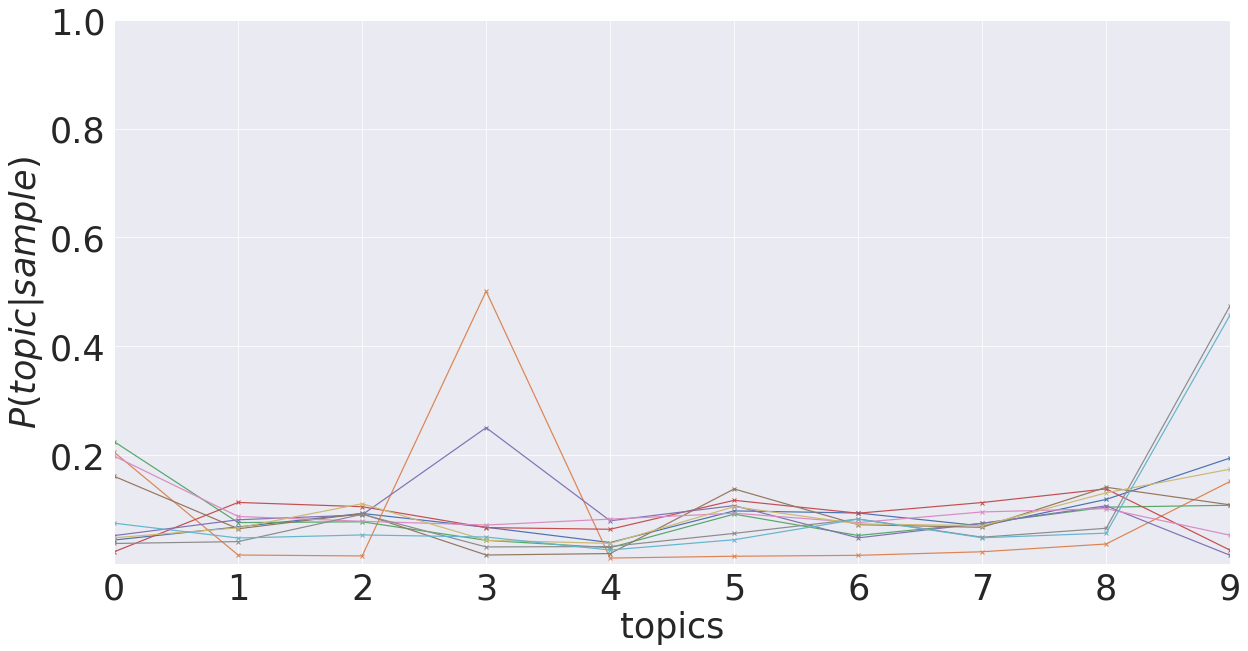

In [120]:
fig=plt.figure(figsize=(20,10))
plt.ylabel("$P(topic | sample$)", fontsize=35)
plt.xlabel("topics", fontsize=35)
for sample in df_Ptd.index.values[:10]:
    plt.plot(df_Ptd.loc[sample,:].astype(float).values, marker='x')
    #plt.plot(np.sort(df_Ptd.filter(F.col('doc')==sample[0]).drop('doc').toPandas().astype(float).values[0])[::-1], lw=0.1, marker='x')
#plt.plot(np.logspace(0,2),1/np.logspace(0,2))
#plt.xscale('log')
#plt.yscale('log')
plt.ylim(1e-4,1)
plt.xlim(0,len(df_Ptd.columns)-2)
plt.tick_params(labelsize=35)
plt.show()
fig.savefig("p_t_s_%s.pdf"%algorithm)

In [121]:
df_mt = pd.read_csv("mainTable.csv",sep=",",index_col=0)
df_mt.index = [g[:15] for g in df_mt.index]
df_files=pd.read_csv("files.dat", index_col=0)
df_mt=df_mt.reindex(index=df_Pwt.index.values.ravel(),
                    columns=[get_file(sample, df_files).name for sample in df_Ptd.index.values.ravel()])
df_mt.dropna(how="all", axis=0, inplace=True)
#df_mt=df_mt.applymap(lambda tpm: np.log2(tpm+1))
#df_mt=df_mt.where(df_mt<1e6,1e6)
df_mt.head()

,GTEX-1117F-0226-SM-5GZZ7,GTEX-1117F-0426-SM-5EGHI,GTEX-1117F-0526-SM-5EGHJ,GTEX-1117F-0626-SM-5N9CS,GTEX-1117F-0726-SM-5GIEN,GTEX-1117F-1326-SM-5EGHH,GTEX-1117F-2426-SM-5EGGH,GTEX-1117F-2526-SM-5GZY6,GTEX-1117F-2826-SM-5GZXL,GTEX-1117F-2926-SM-5GZYI,...,GTEX-ZZPU-1126-SM-5N9CW,GTEX-ZZPU-1226-SM-5N9CK,GTEX-ZZPU-1326-SM-5GZWS,GTEX-ZZPU-1426-SM-5GZZ6,GTEX-ZZPU-1826-SM-5E43L,GTEX-ZZPU-2126-SM-5EGIU,GTEX-ZZPU-2226-SM-5EGIV,GTEX-ZZPU-2426-SM-5E44I,GTEX-ZZPU-2626-SM-5E45Y,GTEX-ZZPU-2726-SM-5NQ8O
ENSG00000268903,2,0,1,1,0,1,1,2,1,2,...,2,3,5,3,2,4,3,2,0,2
ENSG00000269981,3,0,0,1,1,2,1,3,2,2,...,3,4,5,4,3,5,4,2,0,3
ENSG00000225972,3,5,3,2,3,5,2,2,4,3,...,6,3,3,3,4,3,3,3,4,3
ENSG00000229344,3,4,3,2,4,3,3,3,3,3,...,4,4,4,4,4,4,4,4,4,3
ENSG00000178821,0,5,0,0,0,0,0,1,1,1,...,0,5,0,2,1,1,1,0,5,1


In [122]:
Pgt = tf.convert_to_tensor(df_Pwt.values)
Pts = tf.transpose(tf.convert_to_tensor(df_Ptd.values))
Pgs = tf.matmul(Pgt,Pts)
Ps = tf.convert_to_tensor(df_mt.sum(0).values)
Ps = tf.divide(Ps, tf.reduce_sum(Ps))#normalize
Pg = tf.squeeze(tf.matmul(Pgs, tf.reshape(Ps,[Ps.shape[0],1])))

In [123]:
print(Pgt.shape,Pts.shape,Pgs.shape,Pg.shape, Ps.shape)

(435, 11) (11, 17382) (435, 17382) (435,) (17382,)


In [124]:
Pgs_data = Pgs.numpy()
Pg_data = Pg.numpy()
Pgs_data.shape

(435, 17382)

In [125]:
df_Pgs = pd.DataFrame(data=Pgs_data, index=df_Pwt.values.T[0], columns=df_Ptd.index.values.ravel())

In [126]:
A=df_mt.fillna(0).astype(int).sum(1).values

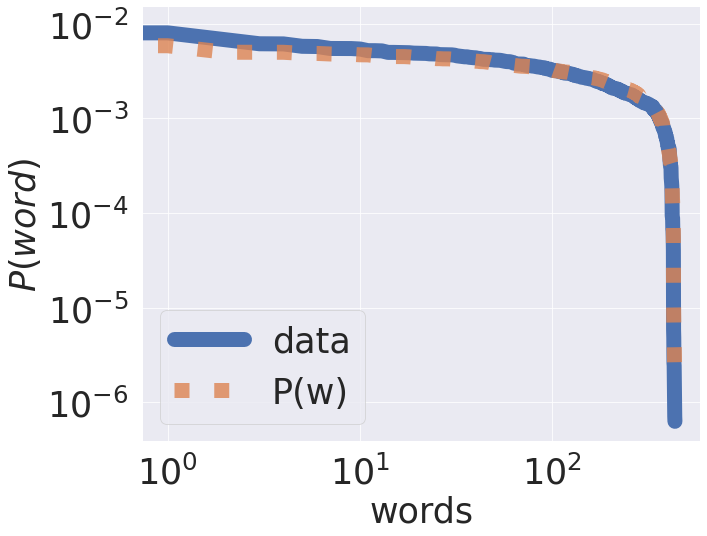

In [127]:
fig=plt.figure(figsize=(10,8))
plt.plot(np.sort(A)[::-1]/A.sum(), lw=15, ls='-', label='data')
plt.plot(np.sort(Pg_data)[::-1]/np.sum(Pg_data), alpha=0.8, lw=15, ls=':', label='P(w)')
plt.ylabel("$P(word$)", fontsize=35)
plt.xlabel("words", fontsize=35)
plt.xscale('log')
plt.yscale('log')
plt.tick_params(labelsize=35)
plt.tick_params(which="both", width=25, length=10, labelsize=35)
plt.legend(fontsize=35)
plt.show()
fig.savefig("p_w_%s.pdf"%algorithm)